<a href="https://colab.research.google.com/github/santiagofloresm/ENEL645-Team25-FinalProject/blob/dev/FinalProject-Phase2_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
## Team 25
Santiago Flores - 30119885

Davis Allan - 10016543

Jordan Joorisity - 30117950

Patrick Pickard - 30116807

Joshua Posyluzny - 30118206

# 1. Loading and pre-processing the dataset

### 1.1 Clone the repository

In [ ]:
!git clone -b dev https://github.com/santiagofloresm/ENEL645-Team25-FinalProject.git

Cloning into 'ENEL645-Team25-FinalProject'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 156957 (delta 50), reused 14 (delta 5), pack-reused 156860
Receiving objects: 100% (156957/156957), 2.87 GiB | 45.56 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Checking out files: 100% (168575/168575), done.


### 1.2 Standard imports

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input

### 1.3 Define the paths

In [ ]:
train_folder = 'ENEL645-Team25-FinalProject/Dataset/Train'
test_folder = 'ENEL645-Team25-FinalProject/Dataset/Alternative_Test'
validation_folder = 'ENEL645-Team25-FinalProject/Dataset/Validation'

### 1.4 Data display

There are 29 classes in the dataset, one for each letter in the English alphabet, one for space, one for delete and a blank one. Below is an example of each one

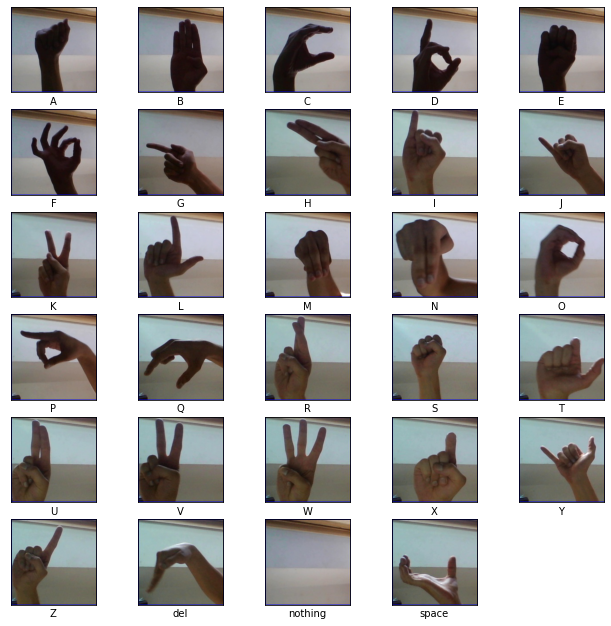

In [ ]:
import matplotlib.pyplot as plt

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

plt.figure(figsize=(11,11))
for i in range (0,29):
  plt.subplot(6,5, i+1)
  plt.xticks([])
  plt.yticks([])
  path = train_folder + "/" + classes[i] + "/" + classes[i] + "2.jpg"
  img = plt.imread(path)
  plt.imshow(img)
  plt.xlabel(classes[i])

### 1.5 Data import and augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_input_dimensions_3d = (200,200,3)
image_input_dimensions_2d = (200,200)
batch_size = 32
seed = 32

#### 1.5.1 Training data

In [ ]:
# https://keras.io/api/preprocessing/image/
# categorical class_mode will be 2D one-hot encoded labels
# The dictionary containing the mapping from class names to class indices can be obtained via the attribute class_indices
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.5, 2.0],
                                    zoom_range=[0.8,1.2],
                                    rotation_range=10,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

train_generator = train_data_gen.flow_from_directory(train_folder, 
                                                     batch_size=batch_size, 
                                                     seed=seed, 
                                                     target_size=image_input_dimensions_2d,
                                                     interpolation='nearest',
                                                     class_mode="categorical",
                                                     subset="training")

Found 69600 images belonging to 29 classes.


#### 1.5.2 Validation data

In [ ]:
val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_data_gen.flow_from_directory(validation_folder, 
                                                 batch_size=batch_size, 
                                                 seed=seed,
                                                 target_size=image_input_dimensions_2d,  
                                                 interpolation='nearest',
                                                 class_mode="categorical")

Found 8700 images belonging to 29 classes.


#### 1.5.3 Test data

In [ ]:
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_data_gen.flow_from_directory(test_folder, 
                                                   batch_size=batch_size, 
                                                   seed=seed,
                                                   target_size=image_input_dimensions_2d,
                                                   interpolation='nearest',
                                                   class_mode="categorical")

Found 870 images belonging to 29 classes.


### 1.6 Training image analysis

In [ ]:
  h, w, r = train_generator.image_shape
  print('There are', train_generator.samples, 'images for training the model')
  print("Approximately {:.0f} images per category".format(train_generator.samples/train_generator.num_classes))
  print('The shape of each image is', train_generator.image_shape)
  print('From which:')
  print('The width is', w)
  print('The height is', h)
  print('And each pixel has a value for each component of RGB for a total of', r)

There are 69600 images for training the model
Approximately 2400 images per category
The shape of each image is (200, 200, 3)
From which:
The width is 200
The height is 200
And each pixel has a value for each component of RGB for a total of 3


### 1.7 Define the callbacks for the VGG16 model

In [ ]:
model_name = "vgg16_asl_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

### 1.8 Define a function for building the model, which will take an input to determine whether or not the model is frozen

In [ ]:
def build_model(training):
  base_model = tf.keras.applications.VGG16(weights='imagenet',
                                           input_shape=image_input_dimensions_3d,
                                           include_top=False)
  if not training:
    base_model.trainable=False
    input_image = tf.keras.Input(shape=image_input_dimensions_3d)
    x1 = base_model(input_image, training=False)
  else:
    base_model.trainable=True
    input_image = tf.keras.Input(shape=image_input_dimensions_3d)
    x1 = base_model(input_image, training=True)
  x2 = tf.keras.layers.Flatten()(x1)
  out = tf.keras.layers.Dense(29, activation='softmax')(x2)
  model = tf.keras.Model(inputs=input_image, outputs=out)
  return model

### 1.9 Define a function for plotting model history

In [ ]:
def plot_accuracy_and_loss(model_history):
  plt.plot(model_history.history['loss'], label = "Train loss")
  plt.plot(model_history.history['val_loss'], label = "Val loss")
  plt.xlabel("Epoch (iteration)")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid()
  plt.show()

  plt.plot(model_history.history['accuracy'], label = "Train accuracy")
  plt.plot(model_history.history['val_accuracy'], label = "Val accuracy")
  plt.xlabel("Epoch (iteration)")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid()
  plt.show()

## 2 Frozen model

###2.1 Build and compile the frozen model

In [ ]:
frozen_model = build_model(training=False)
print(frozen_model.summary())

frozen_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4, clipvalue=0.1, decay=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                534557    
Total params: 15,249,245
Trainable params: 534,557
Non-trainable params: 14,714,688
_________________________________________________________________
None


###2.2 Train the frozen model

In [ ]:
frozen_model_history = frozen_model.fit(train_generator, epochs=5, verbose=1,
                                        callbacks=[early_stop, monitor, lr_schedule],
                                        validation_data=val_generator)

Epoch 1/5
2175/2175 [==============================] - 860s 379ms/step - loss: 4.6974 - accuracy: 0.5482 - val_loss: 0.4177 - val_accuracy: 0.9109
Epoch 2/5
2175/2175 [==============================] - 794s 365ms/step - loss: 0.5315 - accuracy: 0.9031 - val_loss: 0.1872 - val_accuracy: 0.9544
Epoch 3/5
2175/2175 [==============================] - 798s 367ms/step - loss: 0.3167 - accuracy: 0.9392 - val_loss: 0.1951 - val_accuracy: 0.9580
Epoch 4/5
2175/2175 [==============================] - 793s 365ms/step - loss: 0.2270 - accuracy: 0.9554 - val_loss: 0.1685 - val_accuracy: 0.9633
Epoch 5/5
2175/2175 [==============================] - 795s 365ms/step - loss: 0.1354 - accuracy: 0.9710 - val_loss: 0.0872 - val_accuracy: 0.9807


###2.3 Plot the accuracy and loss of the frozen model

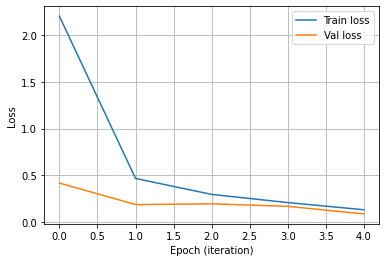

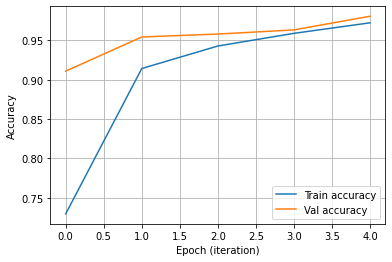

In [ ]:
plot_accuracy_and_loss(frozen_model_history)

##3 Unfrozen model

###3.1 Build and compile the unfrozen model

In [ ]:
unfrozen_model = build_model(training=True)
print(unfrozen_model.summary())

unfrozen_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6, clipvalue=0.1),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 29)                534557    
Total params: 15,249,245
Trainable params: 15,249,245
Non-trainable params: 0
_________________________________________________________________
None


###3.2 Load the weights from the frozen model and train the unfrozen model

In [ ]:
unfrozen_model.load_weights(model_name)
unfrozen_model_history = unfrozen_model.fit(train_generator, epochs = 5, verbose = 1, 
                                            callbacks=[early_stop, monitor, lr_schedule],
                                            validation_data=(val_generator))

Epoch 1/5
2175/2175 [==============================] - 1037s 475ms/step - loss: 0.0870 - accuracy: 0.9823 - val_loss: 0.0250 - val_accuracy: 0.9944
Epoch 2/5
2175/2175 [==============================] - 1033s 475ms/step - loss: 0.0505 - accuracy: 0.9892 - val_loss: 0.0160 - val_accuracy: 0.9962
Epoch 3/5
2175/2175 [==============================] - 1036s 476ms/step - loss: 0.0313 - accuracy: 0.9928 - val_loss: 0.0098 - val_accuracy: 0.9975
Epoch 4/5
2175/2175 [==============================] - 1039s 477ms/step - loss: 0.0275 - accuracy: 0.9940 - val_loss: 0.0050 - val_accuracy: 0.9986
Epoch 5/5
2175/2175 [==============================] - 1034s 475ms/step - loss: 0.0185 - accuracy: 0.9956 - val_loss: 0.0058 - val_accuracy: 0.9987


###3.3 Plot the accuracy and loss of the unfrozen model

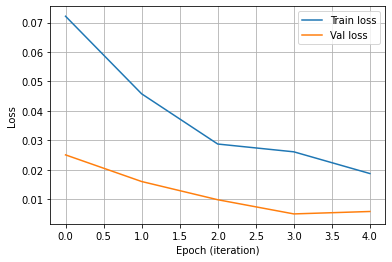

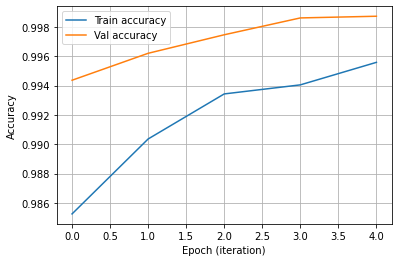

In [ ]:
plot_accuracy_and_loss(unfrozen_model_history)

##4 Evaluate the unfrozen model on the test set

In [ ]:
metrics = unfrozen_model.evaluate(test_generator)
print("Categorical cross-entropy:", round(metrics[0], 3))
print("Accuracy:", round(metrics[1]*100, 2),'%')

28/28 [==============================] - 5s 175ms/step - loss: 15.7970 - accuracy: 0.4207
Categorical cross-entropy: 15.797
Accuracy: 42.07 %


Saving model training history

In [ ]:
import numpy as np

# saving training history to a numpy file
np.save('vgg16_model_history.npy',unfrozen_model_history.history)

Loading model training history

In [ ]:
# loading the training history from numpy file, only need to run if we have to access history again
training_history = np.load('/content/vgg16_model_history.npy',allow_pickle='TRUE').item()

## 5 Testing the model and extracting relevant metrics

In [ ]:
# TODO: update file path of best model weights
best_model_weights_path = "/content/vgg16_asl_cnn.h5"

#### 5.1 Function definitions

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

In [ ]:
# code was acquired from https://www.kaggle.com/danrasband/classifying-images-of-the-asl-alphabet-using-keras

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

#### 5.2 Resetting the test generators and setting shuffle to False

In [ ]:
test_generator.reset()
test_generator = test_data_gen.flow_from_directory(test_folder, 
                                                   batch_size=batch_size, 
                                                   seed=seed, 
                                                   target_size=image_input_dimensions_2d, 
                                                   class_mode="categorical",
                                                   shuffle=False)

Found 870 images belonging to 29 classes.


Classification report and confusion matrix for alternate test data

In [ ]:
# vgg16_model = build_model(training=False)
# vgg16_model.load_weights('/content/vgg16_asl_cnn.h5')
# vgg16_model.summary()

58892288/58889256 [==============================] - 0s 0us/step


OSError: ignored

In [ ]:
predictions_test = unfrozen_model.predict(test_generator)
y_pred = np.argmax(predictions_test, axis=1)
y_true = test_generator.classes

report_alternate = classification_report(y_true, y_pred, target_names=classes)
print(report_alternate)

              precision    recall  f1-score   support

           A       0.33      0.07      0.11        30
           B       0.80      0.40      0.53        30
           C       1.00      0.20      0.33        30
           D       0.31      0.73      0.44        30
           E       0.29      0.07      0.11        30
           F       0.43      0.20      0.27        30
           G       0.75      0.30      0.43        30
           H       0.73      0.73      0.73        30
           I       0.32      0.73      0.44        30
           J       0.57      0.77      0.66        30
           K       0.24      0.53      0.33        30
           L       0.80      0.27      0.40        30
           M       0.33      0.50      0.40        30
           N       0.35      0.27      0.30        30
           O       0.54      0.50      0.52        30
           P       0.60      0.50      0.55        30
           Q       0.91      0.33      0.49        30
           R       0.80    

Confusion matrix, without normalization


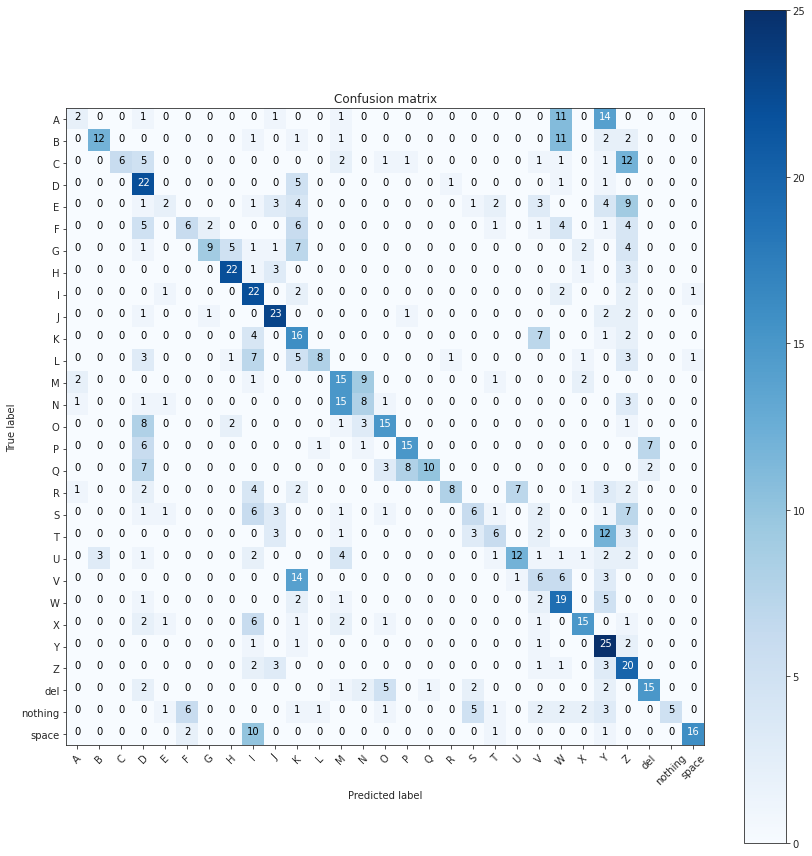

In [ ]:
plot_confusion_matrix_with_default_options(y_pred, y_true, classes)